In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections
from glob import glob
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow


from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *

import astrohack
from astrohack import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# TODO, improvement ideas

# TPOT python auto ml
# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)

# transformer le regresseur en classifier
# ensemble lgbm, xgboost, catboot, NN



#done
# lgbm eval rmsle instead of rmse
# add image size as feature
# CV2 resize cubic interpolation 



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)

mm
a= None

## data folder set up and test

In [4]:
astrohack.dataFolder = 'data/mainData_original/'
dataFolder = 'data/mainData_original/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

# ML part

In [6]:
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')


### Read metadata file

In [7]:
def getAstrohackDataFrame(fileName='metadata_full.csv'):

    if os.path.isfile('F'+fileName):
        df = pd.read_csv('F'+fileName)
    else:
        df =  pd.read_csv(fileName, sep = '\t')

        df['RA'] = df['RA'].apply(np.float64)
        df['DEC'] = df['DEC'].apply(np.float64)
        df['D25'] = df['D25'].apply(np.float64)
        df['redshi'] = df['redshift'].apply(np.float64)
#         df['logMstar'] = df['logMstar'].apply(np.float64) #renamed
#         df['err_logMstar'] = df['err_logMstar'].apply(np.float64) #renamed
        df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
        df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
        df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)
        df['ML'] = df.ML_bayes.apply(np.float64)
        df['ML_error'] = df.ML_bayes_err.apply(np.float64)

#         df['lin_mass'] = np.power(10, df.logMstar)
#         df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

        df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+str(x)+'.npy'))

        # df = df.drop(['logMstar','err_logMstar'], axis=1)

#         df = df[df.logMstar != -99]
        df = df[df.hasFile == True]
#         df = df[df['lin_err']!=0]
        df = df[df.Distance < 600]
#         df = df[df.ML < 15]

        df = df[~df['SDSS_ID'].isin(['1237668349209149549','1237662224593846425','1237648705129283884','1237648703514804436'])] # remove 2 buggy galaxies

#         df['ML_g_rel_err'] = df['ML_g_rel_err'].apply(np.float64)

#         df = df[df['ML_g_rel_err'] != 0]
    
    return df


In [8]:
fileName = 'metadata_refit_valid.csv'

df =  pd.read_csv(fileName, sep = '\t')

print(df.columns)


df =  getAstrohackDataFrame(fileName)


df.head()
df.describe()


Index(['SDSS_ID', 'RA', 'DEC', 'D25', 'redshift', 'GalSize_kpc', 'D_Mpc',
       'd_pix_kpc', 'reduced_chi_square', 'logM_bayes', 'logM_bayes_err',
       'L_g_bayes', 'L_g_bayes_err', 'hasimg', 'isgalaxy', 'M_bayes',
       'M_bayes_err', 'ML_bayes', 'ML_bayes_err', 'mag_g', 'mag_i',
       'ML_zibetti'],
      dtype='object')


,SDSS_ID,RA,DEC,D25,redshift,GalSize_kpc,D_Mpc,d_pix_kpc,reduced_chi_square,logM_bayes,...,M_bayes_err,ML_bayes,ML_bayes_err,mag_g,mag_i,ML_zibetti,redshi,Distance,ML,ML_error
count,7.753100e+04,77531.000000,77531.000000,77531.000000,77531.000000,77531.000000,77531.000000,77531.000000,7.753100e+04,77531.000000,...,7.753100e+04,77531.000000,77531.000000,77502.000000,77507.000000,77483.000000,77531.000000,77531.000000,77531.000000,77531.000000
mean,1.237662e+18,185.366012,25.593291,0.560629,0.055991,36.651731,239.959692,0.465343,1.754167e+00,10.552949,...,5.168584e+09,2.563705,0.192168,16.440004,15.349645,2.474052,0.055991,239.959692,2.563705,0.192168
std,5.869091e+12,57.100670,18.942997,0.195586,0.027726,16.779052,118.826081,0.230434,3.069323e+00,0.665159,...,6.571444e+09,1.251451,0.152872,0.939177,0.988427,1.169084,0.027726,118.826081,1.251451,0.152872
min,1.237646e+18,0.013950,-11.238420,0.407380,0.010000,5.248929,42.857142,0.083111,5.701904e-10,7.442798,...,0.000000e+00,0.055550,0.001158,12.315000,11.039000,0.123109,0.010000,42.857142,0.055550,0.001158
25%,1.237658e+18,154.572900,9.709230,0.436516,0.033400,24.143776,143.142853,0.277590,3.720082e-01,10.186977,...,1.091059e+09,1.607450,0.100179,15.851000,14.735000,1.522845,0.033400,143.142853,1.607450,0.100179
50%,1.237662e+18,186.818850,24.308940,0.501187,0.051300,34.529304,219.857145,0.426359,8.060763e-01,10.698472,...,3.077399e+09,2.657584,0.144569,16.467000,15.345000,2.498393,0.051300,219.857145,2.657584,0.144569
75%,1.237665e+18,222.071550,40.015415,0.602560,0.073800,46.393775,316.285704,0.613359,1.727166e+00,11.039068,...,6.752369e+09,3.360850,0.231947,17.084000,15.992000,3.225753,0.073800,316.285704,3.360850,0.231947
max,1.237680e+18,359.994900,70.133250,10.964781,0.139900,828.365356,599.571424,1.162722,2.999434e+01,12.113630,...,1.286698e+11,24.736745,5.460174,19.094000,18.142000,15.459370,0.139900,599.571424,24.736745,5.460174


### Filter images that have no known mass, no actual image, or with an unknown error

In [9]:
print(len(df.SDSS_ID.values))

77531


In [10]:
vgg16 = None
r50 = None
cnn = None

In [11]:

runNameParams.append('ReadLog1pNormCrop.75origOldCleanup')

postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']
distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]
numFeatures = 0

def getFeatures(preProcessingNum):
    global vgg16, r50, cnn,numFeatures
    
    if vgg16 == None:
        vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
    if r50 == None:
        r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
#     if cnn == None:
#         cnn = load_model('encoder.h5')
    Xg3r50 = []
    Xg3vgg16 = []
    postImgFeatures = []
    csize=2
    preImgFeatures = []
    cnnFeatures = []

    maxChunkNumber = math.ceil(len(ids)/chunkSize)
    chunkStart = 0
    # for chunkStart in tqdm(range(0, 3)):
    
    # do the loading by chunk to avoid consuming too much memory
    for chunkStart in tqdm(range(0, len(ids), chunkSize)):
        curChunk = int((chunkStart//chunkSize))
        valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

        Xg_ = []
        pre_ex_ = []

        # preprocess the image and collect some raw image stats
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            X = read_image(ids[i])
            Xg_.append(img_preprocnoread(X, preProcessingNum))
            pre_ex_.append([
                X.sum(),
                X.min(),
                X.max(),
                X.mean(),
                X.std(),
                X[X.shape[0]//2,X.shape[1]//2],
                np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
                X.shape[0], 
            ])

        # stack the postprocessing
        pre_ex = np.stack(pre_ex_)
        Xg = np.stack(Xg_)

        # collect some post processing stats
        post_ex = np.hstack([
            np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
            np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
            ])

        
#         cnnFeatures_ = cnn.predict( Xg[:,:,:,newaxis])
#         cnnFeatures_ = cnnFeatures.reshape(valuesInThisChunk, -1)
        
        # prepare correct dimension to feed to imagenet networks
        Xg3 = np.zeros((valuesInThisChunk,224,224,3))
        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        # do r50 prediction
        Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
        Xg3vgg16_ = vgg16.predict(Xg3)
        


        if chunkStart == 0:
            Xg3r50 = Xg3r50_
            Xg3vgg16 = Xg3vgg16_
            preImgFeatures = pre_ex
            postImgFeatures = post_ex
#             cnnFeatures = cnnFeatures_
        else:
            Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
            Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
            preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
            postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)
#             cnnFeatures = np.concatenate([cnnFeatures, cnnFeatures_], axis = 0)


    # add features from the data itself (distance)
    Distance = df.Distance.values[:N].reshape(N,1)

    Xg3f = np.hstack ( ( 
            Xg3r50, 
            Xg3vgg16, 
#             cnnFeatures,
            Distance,
            1/Distance,
            Distance**2,
            1/(Distance**2),
            Distance**3,
            1/(Distance**3),
            np.log(Distance),
            1/np.log(Distance),
            np.log(Distance**2),
            1/np.log(Distance**2),
            np.log(Distance)**2,
            1/np.log(Distance)**2,
            preImgFeatures,
            postImgFeatures
            ) )


    Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
                + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
#                 + [prefixThisRound+'.cnn.' + str(i) for i in range(cnnFeatures.shape[1])] 
                + [prefixThisRound+'.'+ n for n in distanceNames]
                + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
                + [prefixThisRound+'.'+ n for n in postImgFeatureNames])
    return Xg3f, Xg3fNames

# numFeatures = 2048 + 1000 + 7*7 *8 + len(postImgFeatureNames) + len(preImgFeatureNames) + len(distanceNames) 
numFeatures = 2048 + 1000 + len(postImgFeatureNames) + len(preImgFeatureNames) + len(distanceNames) 

    

In [12]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}



In [13]:
def lgb_chi2(Yp, train_data):
    Y = train_data.get_label()
    err = 1/train_data.get_weight()**0.5
    return 'Chi²', round(xi2(Y,Yp,err),1), False


In [14]:
def getLGBMModelsWithCV(trainSet, YSet, errSet):
    kf = KFold(n_splits=nSplits,shuffle=True, random_state=220477)

    cvtrainpreds = np.zeros([len(trainSet),nSplits])
    models = []
    counter = 0
    for tix, vix in kf.split(trainSet):
        X_train, X_test = trainSet[tix], trainSet[vix]
        Y_train, Y_test = YSet[tix], YSet[vix]

        lgb_train = lgbm.Dataset(X_train, Y_train)
        lgb_eval = lgbm.Dataset(X_test, Y_test)

        lgb_train.set_weight(1/errSet[tix]**2)
        lgb_eval.set_weight(1/errSet[vix]**2)
        
        gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=maxBoostRuns,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100,
                        feval = lgb_chi2
                        )
        models.append(gbm)

        p = gbm.predict(X_test)

        cvtrainpreds[vix,counter] = p
        counter = counter+1
        
    return models, cvtrainpreds

# models, cvtrainpreds, xis, linxis = getModels(Xg3f[:M], Y[:M])

# print(models, cvtrainpreds)

# print(xis, linxis)


In [15]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**6,
    'learning_rate': 0.01,
    'max_depth': 12,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    'min_child_weight': 2,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

def getLGBMModelsNoCV(trainSet, YSet, errSet):
    cvtrainpreds = np.zeros([len(trainSet),1])
    models = []
    counter = 0

    tix, vix = list(range(0,int(len(trainSet)*0.9))), list(range(int(len(trainSet)*0.9),len(trainSet)))
    
    X_train, X_test = trainSet[tix], trainSet[vix]
    Y_train, Y_test = YSet[tix], YSet[vix]

    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)

    lgb_train.set_weight(1/errSet[tix]**2)
    lgb_eval.set_weight(1/errSet[vix]**2)

    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=maxBoostRuns,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=300,
                       feval = lgb_chi2
                    )
    models.append(gbm)

    p = gbm.predict(X_test)
    cvtrainpreds[vix,counter] = p
    counter = counter+1
        
    return models, cvtrainpreds


In [16]:
TRAIN = 0
TEST = 4

FEATURES = 0
TRUTH = 1
ERROR = 2
LINERROR = 3

ID = 8
FEATURENAMES = 9

data = list(range(10))


In [17]:
# breakqsdqsd

# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [18]:
df = df.sample(frac=1).reset_index()

In [19]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)

prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

prefixThisRound = prefixThisRound + '-model12'
    
chunkSize = 200
# nSplits = 3
reloadImagesAndPreprocess = 1
numPreprocessing = 1
nSplits = 1

maxBoostRuns = 30000 # 30000
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout
# N = int(N*0.1)
# M = int(M*0.1)


# N = int(N*0.01)
# M = int(M*0.01)


In [20]:
# df.ML_error = df.ML_error.clip(0.05,None)

In [21]:
df.columns

Index(['index', 'SDSS_ID', 'RA', 'DEC', 'D25', 'redshift', 'GalSize_kpc',
       'D_Mpc', 'd_pix_kpc', 'reduced_chi_square', 'logM_bayes',
       'logM_bayes_err', 'L_g_bayes', 'L_g_bayes_err', 'hasimg', 'isgalaxy',
       'M_bayes', 'M_bayes_err', 'ML_bayes', 'ML_bayes_err', 'mag_g', 'mag_i',
       'ML_zibetti', 'redshi', 'Distance', 'ML', 'ML_error', 'hasFile'],
      dtype='object')

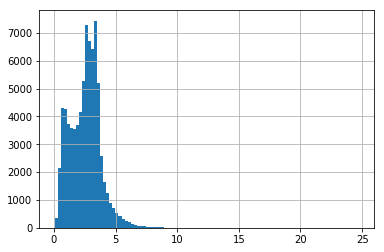

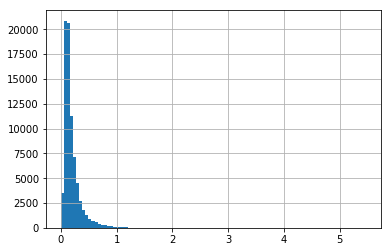

In [22]:
df.ML.hist(bins=100)
plt.figure()
df.ML_error.hist(bins=100)

In [23]:
ids = df.SDSS_ID.values[:N]
#Y = df.logMstar.values[:N]
Y = df.ML.values[:N]
err = df.ML_error.values[:N] * Y
# Y_lin = df.lin_mass.values[:N]
# err_lin = df.lin_err.values[:N]

In [24]:
# plt.hist(err, bins=100)

In [25]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

77531
69777
200
sp-newSource-ReadLog1pNormCrop.75origOldCleanup-model12


In [26]:
ttaPredictions = np.zeros([numPreprocessing,nSplits,N-M])


data[TRAIN+FEATURES] = np.ones([0,numFeatures])
data[TRAIN+TRUTH] = np.ones([0])
data[TRAIN+ERROR] = np.ones([0])
data[TRAIN+LINERROR] = np.ones([0])
data[TEST+FEATURES] = np.ones([0,numFeatures])
data[TEST+TRUTH] = np.ones([0])
data[TEST+ERROR] = np.ones([0])
data[TEST+LINERROR] = np.ones([0])


data[ID] = ids


curPreproc = PP_LOG1P+PP_NORMALIZE+PP_CROP+PP_HACKATON
fileName = prefixThisRound + '-' + str(N) + 'allFeatures' + str(curPreproc) + '.npy'
if reloadImagesAndPreprocess == 1 or not(os.path.isfile(fileName)):
    for curTTA in range(numPreprocessing):
        a, Xg3fNames = getFeatures(curTTA+curPreproc)

        data[TRAIN+FEATURES] = np.vstack([data[TRAIN+FEATURES],a[:M]])
        data[TRAIN+TRUTH] = np.hstack([data[TRAIN+TRUTH],Y[:M]])
        data[TRAIN+ERROR] = np.hstack([data[TRAIN+ERROR],err[:M]])

        data[TEST+FEATURES] = np.vstack([data[TEST+FEATURES],a[M:]])
        data[TEST+TRUTH] = np.hstack([data[TEST+TRUTH],Y[M:]])
        data[TEST+ERROR] = np.hstack([data[TEST+ERROR],err[M:]])

    np.save(fileName, data)
else:
    data = np.load(fileName)


print("loaded")

100%|██████████| 388/388 [2:35:18<00:00, 21.71s/it]  


loaded


In [27]:
from keras.models import load_model

In [33]:
models, cvtrainpreds = getLGBMModelsNoCV(data[TRAIN+FEATURES], data[TRAIN+TRUTH], data[TRAIN+ERROR])

ppreds = np.zeros([len(models),data[TEST+FEATURES].shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(data[TEST+FEATURES])
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)
mpred = ppreds.reshape((numPreprocessing,-1)).mean(axis=0)
print("Iteration : {}".format(numPreprocessing))


Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 0.893962	training's Chi²: 5502.4	valid_1's rmse: 1.2306	valid_1's Chi²: 13546
[200]	training's rmse: 0.329125	training's Chi²: 745.8	valid_1's rmse: 0.739831	valid_1's Chi²: 4896
[300]	training's rmse: 0.124602	training's Chi²: 106.9	valid_1's rmse: 0.573069	valid_1's Chi²: 2937.6
[400]	training's rmse: 0.054353	training's Chi²: 20.3	valid_1's rmse: 0.545023	valid_1's Chi²: 2657.1
[500]	training's rmse: 0.0345373	training's Chi²: 8.2	valid_1's rmse: 0.53824	valid_1's Chi²: 2591.4
[600]	training's rmse: 0.0298864	training's Chi²: 6.1	valid_1's rmse: 0.548289	valid_1's Chi²: 2689
[700]	training's rmse: 0.0283177	training's Chi²: 5.5	valid_1's rmse: 0.561276	valid_1's Chi²: 2817.9
[800]	training's rmse: 0.0273474	training's Chi²: 5.1	valid_1's rmse: 0.587629	valid_1's Chi²: 3088.8
Early stopping, best iteration is:
[504]	training's rmse: 0.0341939	training's Chi²: 8.1	valid_1's rmse: 0.537931	valid_1's C

Iteration : 1


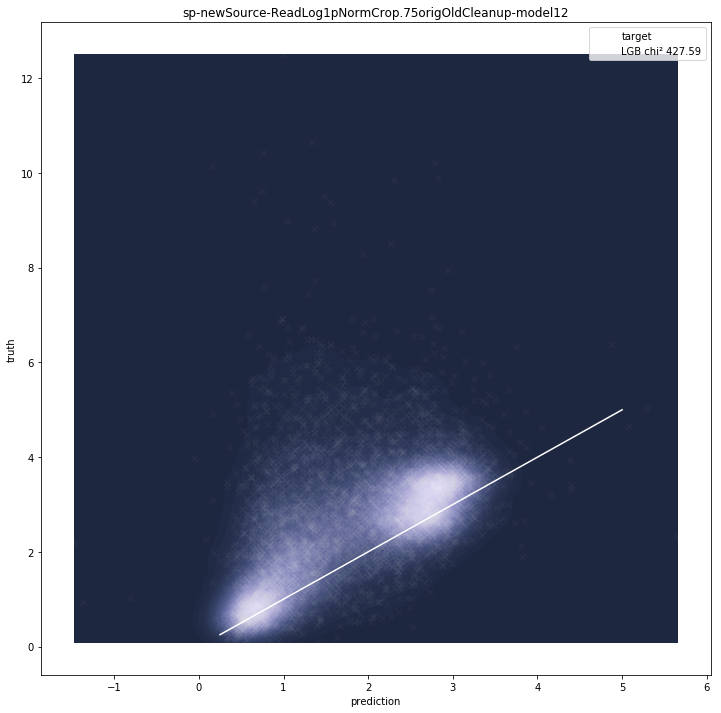

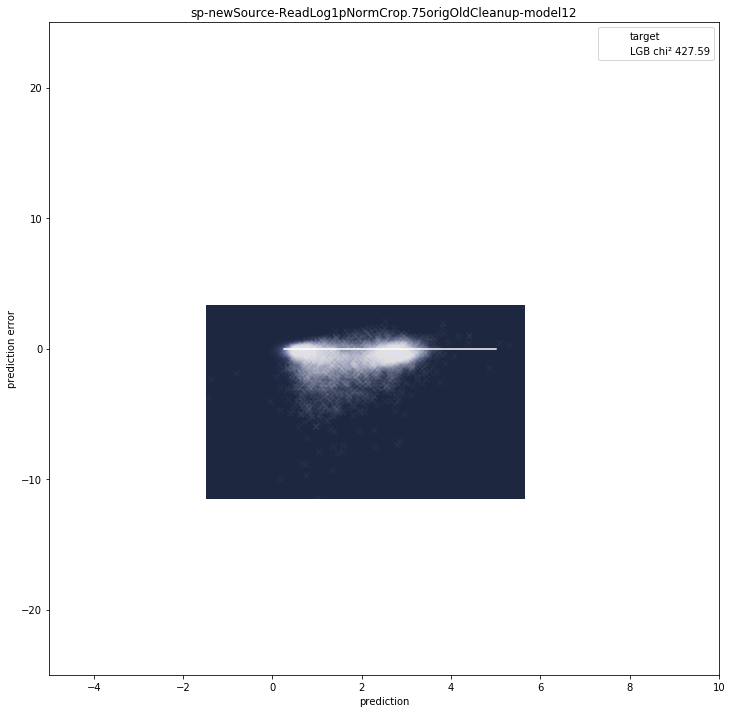

In [34]:

mpred = ppreds.reshape((numPreprocessing,-1)).mean(axis=0)
print("Iteration : {}".format(numPreprocessing))

# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

linChiSq = xi2(mpred, data[TEST+TRUTH], data[TEST+ERROR])

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')
# plt.xlim([0,10])
# plt.ylim([0,12])

plt.legend()
plt.show()

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, mpred-data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0,0], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('prediction error')
plt.xlim([-5,10])
plt.ylim([-25,25])
plt.legend()
plt.show()

In [30]:
df[df.ML < 0.2][['ML', 'Distance', 'ML_error']]

,ML,Distance,ML_error
192,0.060248,45.428570,0.009574
250,0.191021,66.428570,0.033699
255,0.180465,202.285722,0.027986
280,0.152977,76.714283,0.020633
646,0.131268,66.857141,0.009733
1093,0.055550,70.714285,0.003611
3797,0.139766,165.428578,0.021000
4488,0.063092,113.571427,0.006481
4596,0.132631,214.285717,0.022124
6242,0.175092,97.714287,0.028334


1

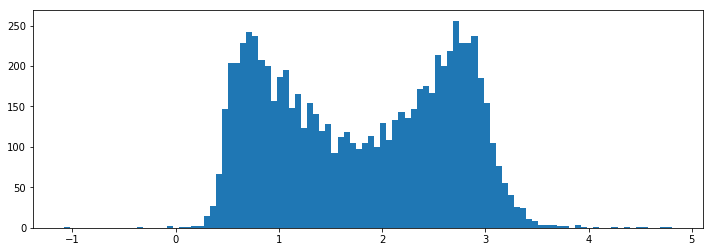

In [31]:
plt.figure(figsize=(12,4))
plt.hist(mpred,bins=100)
1

In [32]:
&é"&éazeaze"

SyntaxError: invalid syntax (<ipython-input-32-2105495a1123>, line 1)

In [ ]:
plt.hist(data[TRAIN+ERROR], bins=100);

# import keras


In [ ]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    epochsPerDraw = 10
    referencePrediction = None
    
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.test_losses = [] # external validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        self.lasttrainplot = None
        self.lasttestplot = None
        
    def on_train_begin(self, logs={}):
        self.initVars()
        self.referenceLoss = xi2(self.referencePrediction, data[TEST+TRUTH], data[TEST+ERROR])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        currentLearningRate = K.get_value(model.optimizer.lr)
        self.lr.append(currentLearningRate)

        if ( self.i %self.epochsPerDraw != 0 ):
            return

        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.suptitle("{}/{} {} {}".format(self.i, numEpochs, curloss, prefixThisRound))
        
#         ax = plt.subplot(131) # self values
#         if self.lasttrainplot == None or self.i %self.epochsPerDraw == 0:
#             self.plotSelfTrain(ax)
#         else:
#             ax = self.lasttrainplot

        ax = plt.subplot(121)
        if self.lasttestplot == None or self.i %self.epochsPerDraw == 0:
            self.plotSelfTest(ax)
        else:
            ax = self.lasttestplot
    
        ax = plt.subplot(122)
        self.plotLosses(ax)
        

        plt.savefig("pltsave/" + prefixThisRound + "%05d.png" % self.i)
        plt.show();
    
    def plotSelfTrain(self, ax):

        pred = model.predict(data[TRAIN+FEATURES])[:,0]
#         r = rmse(pred,data[TRAIN+TRUTH])
        r = xi2(pred,data[TRAIN+TRUTH], data[TRAIN+ERROR])
        plt.scatter(x=data[TRAIN+TRUTH], y=pred, c='k', alpha=.1, label="NN train {:.2f}".format(r))
#         sns.kdeplot(data[TRAIN+TRUTH], pred,n_levels=10, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
#         plt.plot([7, 13], [0,0], 'k-', lw=2, label="target")
#         axes = plt.gca()
#         axes.set_xlim([7,13])
        plt.legend()
        self.lasttrainplot = ax
    
    def plotSelfTest(self, ax):
        
        # lgbm values
        plt.scatter(x=data[TEST+TRUTH], 
                    y=self.referencePrediction, 
                    c='b', alpha=.1, label="ref {:02f}".format(self.referenceLoss))
        
        # test values
        pred = model.predict(data[TEST+FEATURES])[:,0]
        r = xi2(pred,data[TEST+TRUTH], data[TEST+ERROR])
        plt.scatter(x=data[TEST+TRUTH], y=pred, c='g', alpha=.1, label="NN test {:.2f}".format(r))
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
        plt.plot([0, 12], [0, 12], 'k-', lw=2, label="target")
#         axes = plt.gca()
#         axes.set_xlim([7,13])
        plt.legend()
        self.lasttestplot = ax

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        ax.set_yscale("log", nonposy='clip')
        ax.axhline(self.referenceLoss,linestyle='--')
        plt.legend()
        ax2 = ax.twinx()
        ax2.set_yscale('log')
        plt.plot(self.x,self.lr, c='r', label='learning rate', alpha=0.8)
        
#         plt.plot(self.x, self.testrmse, label="test rmse", c='g')
        plt.legend()

        
plot_losses = PlotLosses()

In [ ]:
import models


In [ ]:
print(data[TRAIN+FEATURES].shape)
print(data[TRAIN+TRUTH].shape)

In [ ]:
print(set(np.argwhere(np.isnan(data[TRAIN+FEATURES]))[:,1]))
print(set(np.argwhere(np.isnan(data[TEST+FEATURES]))[:,1]))

In [ ]:
# test keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.optimizers import *

model = Sequential()

model.add(Dense(1000, input_shape=(data[TRAIN+FEATURES].shape[1],), activation = 'relu', kernel_initializer='truncated_normal',))
# model.add(Dropout(0.5))

model.add(Dense(500, activation='relu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(300, activation='elu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='elu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='elu',kernel_initializer='truncated_normal'))

model.compile(optimizer='nadam', loss='mse')


reduceLRcallback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=300, verbose=0, mode='auto', epsilon=0.0001, cooldown=20, min_lr=1e-8)

numEpochs = 30000
plot_losses.epochsPerDraw = 20
plot_losses.referencePrediction = mpred
# num = 5000
num = N

model.fit(data[TRAIN+FEATURES][:num,:], 
          data[TRAIN+TRUTH][:num], 
          sample_weight=1/(data[TRAIN+ERROR][:num])**2,
          batch_size=1000, 
          epochs=numEpochs, 
          validation_split = 0.1, 
          verbose = 1,
          callbacks=[plot_losses,reduceLRcallback])

In [ ]:
# %pastebin 1

In [ ]:
currentLearningRate = K.get_value(model.optimizer.lr)
print(currentLearningRate)
# K.set_value(model.optimizer.lr, currentLearningRate*.8)

In [ ]:
reduceLRcallback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=100, verbose=0, mode='auto', epsilon=0.0001, cooldown=20, min_lr=0)
continueTraining=0

In [ ]:
# uncomment this as needed
# continueTraining = 1

# add extra big ones
# indexes = np.where(data[TRAIN+TRUTH] > 5)[0]
# data[TRAIN+TRUTH] = np.hstack([data[TRAIN+TRUTH],data[TRAIN+TRUTH][indexes]])
# data[TRAIN+FEATURES] = np.vstack([data[TRAIN+FEATURES],data[TRAIN+FEATURES][indexes]])

In [ ]:
if continueTraining == 1:
    plot_losses.referencePrediction = mpred
    numEpochs = 30000
    # keep training
    model.fit(data[TRAIN+FEATURES][:num,:], 
              data[TRAIN+TRUTH][:num], 
              sample_weight=1/(data[TRAIN+ERROR][:num])**2,
              batch_size=1000, 
              epochs=numEpochs, 
              validation_split = 0.1, 
              verbose = 1,
              callbacks=[plot_losses,reduceLRcallback])

In [ ]:
x = model.predict(data[TEST+FEATURES])[:,0]
# print(x)

linChiSq = xi2(data[TEST+TRUTH],x,data[TEST+ERROR])
print(linChiSq)

g = sns.jointplot(x=cvpred, y=data[TEST+TRUTH], alpha=.3)
g.x = x
g.y = data[TEST+TRUTH]
g.plot_joint(plt.scatter, alpha=.3, c='r')
plt.suptitle('dataSize:{} epochs:{}'.format(num,numEpochs))

plt.legend(['lgbm', 'keras-rmsprop'])
# sns.jointplot(x=x[:,0], y=cvpred)

In [ ]:
# model.save(prefixThisRound + "." + str(numEpochs) + ".h5" )



x = model.predict(data[TEST+FEATURES])[:,0]
print(rmse(x,data[TEST+TRUTH]))

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, error(logM) distribution')
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.1, c='k')
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
plt.plot([7,13],[0,0], 'k-')

In [ ]:
linChiSq = xi2(data[TEST+TRUTH],cvpred,data[TEST+ERROR])


plt.figure(figsize=(16,16))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60,shade_lowest=False, )
sns.kdeplot(cvpred, data[TEST+TRUTH], alpha=0.99, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, bw=0.2, cut=0, n_levels=20, alpha=0.5)
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()

In [ ]:
plt.figure(figsize=(12,12))
# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

plt.title(prefixThisRound)
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60,shade_lowest=False, )
sns.kdeplot(cvpred, data[TEST+TRUTH], alpha=0.99, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=cvpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, bw=0.2, cut=0, n_levels=20, alpha=0.5)
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()

In [ ]:
azeazeaze
# run the next one for same with cross validation

In [35]:
nSplits = 10
models, cvtrainpreds = getLGBMModelsWithCV(data[TRAIN+FEATURES], data[TRAIN+TRUTH], data[TRAIN+ERROR])

ppreds = np.zeros([len(models),data[TEST+FEATURES].shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(data[TEST+FEATURES])
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.89292	training's Chi²: 5653.9	valid_1's rmse: 1.15392	valid_1's Chi²: 9440.8
[200]	training's rmse: 0.328663	training's Chi²: 766	valid_1's rmse: 0.75396	valid_1's Chi²: 4030.5
[300]	training's rmse: 0.12419	training's Chi²: 109.4	valid_1's rmse: 0.599479	valid_1's Chi²: 2548.1
[400]	training's rmse: 0.053801	training's Chi²: 20.5	valid_1's rmse: 0.578828	valid_1's Chi²: 2375.5
[500]	training's rmse: 0.0337515	training's Chi²: 8.1	valid_1's rmse: 0.564311	valid_1's Chi²: 2257.9
[600]	training's rmse: 0.0290685	training's Chi²: 6	valid_1's rmse: 0.557784	valid_1's Chi²: 2205.9
[700]	training's rmse: 0.0275976	training's Chi²: 5.4	valid_1's rmse: 0.558986	valid_1's Chi²: 2215.5
Early stopping, best iteration is:
[639]	training's rmse: 0.0283682	training's Chi²: 5.7	valid_1's rmse: 0.556828	valid_1's Chi²: 2198.4
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.89

Iteration 0: 374.12200693587005
Iteration 1: 864.2430507597821
Iteration 2: 557.5093090839594
Iteration 3: 356.3442387899466
Iteration 4: 447.68976931161563
Iteration 5: 569.4306050742149
Iteration 6: 412.74917301629773
Iteration 7: 478.113737330114
Iteration 8: 312.1794631191001
Iteration 9: 289.34453599227436


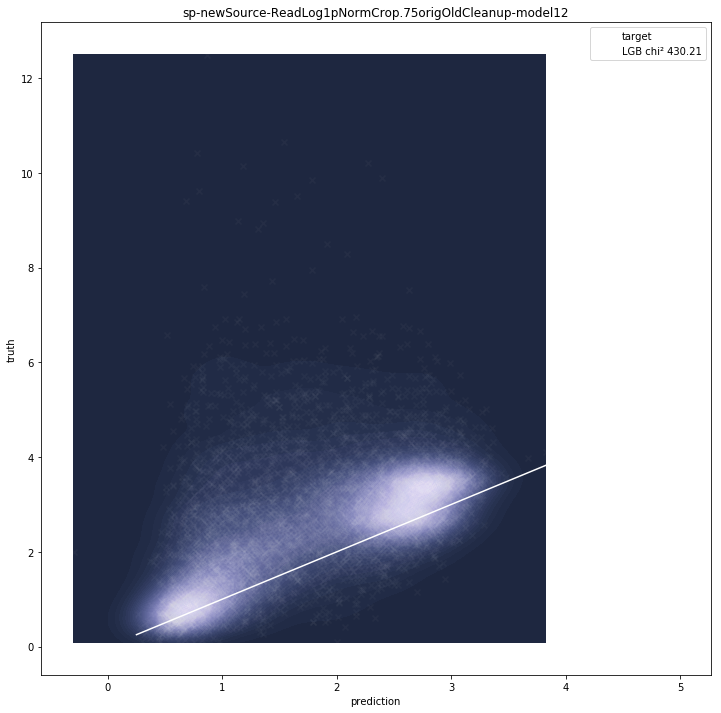

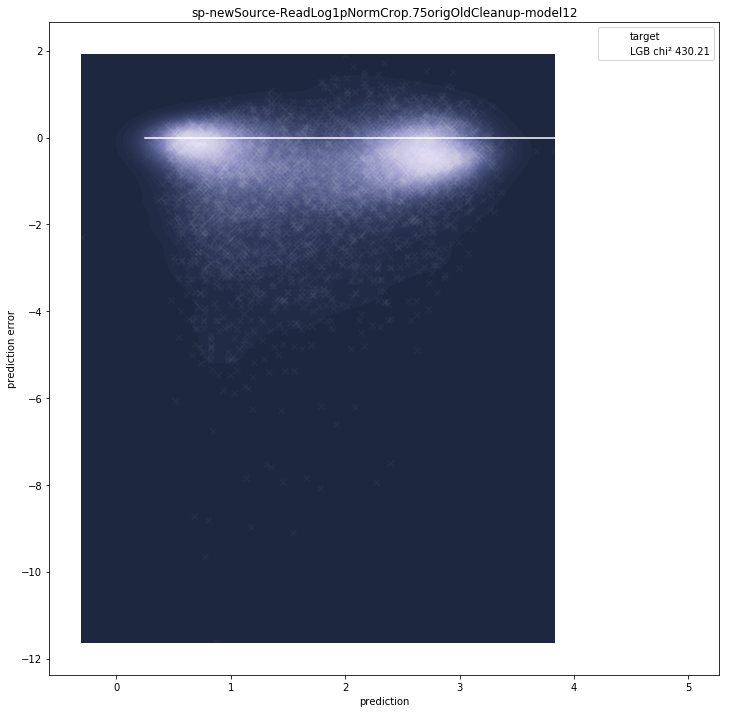

In [36]:
for i in range(len(ppreds)):
    linChiSq = xi2(ppreds[i], data[TEST+TRUTH], data[TEST+ERROR])
    print("Iteration {}: {}".format(i, linChiSq))

mpred = ppreds.reshape((10,-1)).mean(axis=0)

# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

linChiSq = xi2(mpred, data[TEST+TRUTH], data[TEST+ERROR])

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()
plt.show()

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, mpred-data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0,0], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('prediction error')

plt.legend()
plt.show()